# ANALYSIS

In [ ]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [28]:
import pandas as pd
import numpy as np
import sklearn
import pyreadr

#statistics
from scipy.stats import chi2_contingency, ttest_ind

# import cudf #gpu-powered DataFrame (Pandas alternative)

# #imbalance handling
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
# from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler


#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, train_test_split

#performance metrices
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

from sklearn import metrics
#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from cuml.svm import SVC #gpu-powered SVM

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, Input, concatenate, Reshape, Activation, Flatten, Add, BatchNormalization, Multiply, LeakyReLU
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import AUC, SensitivityAtSpecificity
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, Adamax, SGD, Adadelta
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import L1L2, L1, L2

#Tree pruning
from sklearn.tree._tree import TREE_LEAF


#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

from collections import Counter
import os
# import torch

random_state = 42

In [3]:
#Model evaluation function

def summariseResult (testX, testY, model):
    preds = model.predict_proba(testX)
    preds = [x[1] for x in preds]
    # tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    # specificity = tn / (tn+fp)
    # sensitivity = tp / (tp+fn)
    # ppv = 100*tp/(tp+fp)
    # npv = 100*tn/(fn+tn)
    # acc = accuracy_score(testY, preds)
    # f1score = f1_score(testY, preds, average = 'binary')
    # balanceacc = balanced_accuracy_score(testY, preds)
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    # aucscore = auc(fpr, tpr)
    aucscore = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(aucscore,4), np.round(auprc,4)
    # return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)



## Naive - only prev attacks

In [12]:
# Data loader
# features = pd.read_csv("../FinalData/cleaned_features_11072023.csv")
gridSearchData, crossValData, internalEvaluationData, externalEvaluationData = pickle.load(open('../../Clean_data/dataset_2vs1_25102024.sav', 'rb'))
outcomes = pd.read_csv("../../Clean_data/cleaned_outcomes_24102024.csv")
gridSearchData['numAsthmaAttacks_binary'] = gridSearchData['numAsthmaAttacks'].apply(lambda x: 0 if x==0 else 1)
crossValData['numAsthmaAttacks_binary'] = crossValData['numAsthmaAttacks'].apply(lambda x: 0 if x==0 else 1)
internalEvaluationData['numAsthmaAttacks_binary'] = internalEvaluationData['numAsthmaAttacks'].apply(lambda x: 0 if x==0 else 1)
externalEvaluationData['numAsthmaAttacks_binary'] = externalEvaluationData['numAsthmaAttacks'].apply(lambda x: 0 if x==0 else 1)

In [13]:
#previous attacks binary

## Feature columns
feature_columns_main = ['numAsthmaAttacks_binary']

target_outcome = 'outcome_12months'
X = crossValData[feature_columns_main]
X_grid = gridSearchData[feature_columns_main]
X = pd.concat([X, X_grid])
X.reset_index(drop=True, inplace=True)
y = crossValData[target_outcome]
y_grid = gridSearchData[target_outcome]
y = pd.concat([y, y_grid])
y.reset_index(drop=True, inplace=True)
X_internalVal = internalEvaluationData[feature_columns_main]
X_externalVal_binary = externalEvaluationData[feature_columns_main]
y_internalVal = internalEvaluationData[target_outcome]
y_externalVal_binary = externalEvaluationData[target_outcome]

print(X.shape)
print(y.shape)
print(X_internalVal.shape)
print(X_externalVal_binary.shape)



(474188, 1)
(474188,)
(121714, 1)
(19860, 1)


In [14]:
print(roc_auc_score(X.values, y.values))
print(roc_auc_score(X_internalVal.values, y_internalVal.values))
print(roc_auc_score(X_externalVal_binary.values, y_externalVal_binary.values))

0.6099309058018705
0.6087761117150404
0.5920940190679757


In [15]:
tn, fp, fn, tp = confusion_matrix(X.values, y.values).ravel()
print(f'specificity = {tn / (tn+fp)}')
sensitivity = tp / (tp+fn)

specificity = 0.9290623705505674


## num attacks + confounding (age, sex, BMI, ethnic, imd)

In [36]:
gridSearchData, crossValData, internalEvaluationData, externalEvaluationData = pickle.load(open('../../Clean_data/dataset_scaled_2vs1_25102024.sav', 'rb'))
outcomes = pd.read_csv("../../Clean_data/cleaned_outcomes_24102024.csv")
gridSearchData['numAsthmaAttacks_binary'] = gridSearchData['numAsthmaAttacks'].apply(lambda x: 0 if x==0 else 1)
crossValData['numAsthmaAttacks_binary'] = crossValData['numAsthmaAttacks'].apply(lambda x: 0 if x==0 else 1)
internalEvaluationData['numAsthmaAttacks_binary'] = internalEvaluationData['numAsthmaAttacks'].apply(lambda x: 0 if x==0 else 1)
externalEvaluationData['numAsthmaAttacks_binary'] = externalEvaluationData['numAsthmaAttacks'].apply(lambda x: 0 if x==0 else 1)

In [37]:
feature_columns_adjusted = ['numAsthmaAttacks_binary', 'age', 'sex', 'BMI_cat_normal',
       'BMI_cat_not recorded', 'BMI_cat_obese', 'BMI_cat_overweight',
       'BMI_cat_underweight', 'ethnic_group_Asian', 'ethnic_group_Black',
       'ethnic_group_Mixed', 'ethnic_group_Other', 'ethnic_group_White',
       'ethnic_group_not recorded', 'smokingStatus_current',
       'smokingStatus_former', 'smokingStatus_never', 'imd_decile_0',
       'imd_decile_1', 'imd_decile_2', 'imd_decile_3', 'imd_decile_4',
       'imd_decile_5', 'imd_decile_6', 'imd_decile_7', 'imd_decile_8',
       'imd_decile_9', 'imd_decile_10']

feature_columns_adjusted_cont = ['numAsthmaAttacks', 'age', 'sex', 'BMI_cat_normal',
       'BMI_cat_not recorded', 'BMI_cat_obese', 'BMI_cat_overweight',
       'BMI_cat_underweight', 'ethnic_group_Asian', 'ethnic_group_Black',
       'ethnic_group_Mixed', 'ethnic_group_Other', 'ethnic_group_White',
       'ethnic_group_not recorded', 'smokingStatus_current',
       'smokingStatus_former', 'smokingStatus_never', 'imd_decile_0',
       'imd_decile_1', 'imd_decile_2', 'imd_decile_3', 'imd_decile_4',
       'imd_decile_5', 'imd_decile_6', 'imd_decile_7', 'imd_decile_8',
       'imd_decile_9', 'imd_decile_10']

In [38]:
#previous attacks adjusted

target_outcome = 'outcome_12months'
X = crossValData[feature_columns_adjusted]
X_grid = gridSearchData[feature_columns_adjusted]
X = pd.concat([X, X_grid])
X.reset_index(drop=True, inplace=True)
y = crossValData[target_outcome]
y_grid = gridSearchData[target_outcome]
y = pd.concat([y, y_grid])
y.reset_index(drop=True, inplace=True)
X_internalVal = internalEvaluationData[feature_columns_adjusted]
X_externalVal = externalEvaluationData[feature_columns_adjusted]
y_internalVal = internalEvaluationData[target_outcome]
y_externalVal = externalEvaluationData[target_outcome]


print(X.shape)
print(y.shape)
print(X_internalVal.shape)
print(X_externalVal.shape)

# roc_auc_score(X.values, y.values)

(474188, 28)
(474188,)
(121714, 28)
(19860, 28)


In [39]:
lrmodel1 = LogisticRegression(class_weight='balanced')
lrmodel1.fit(X,y)

print(summariseResult(X_internalVal, y_internalVal, lrmodel1))
print(summariseResult(X_externalVal, y_externalVal, lrmodel1))

(0.7211, 0.2724)
(0.6938, 0.3001)


## num attacks + confounding (age, sex, BMI, ethnic, imd)

In [20]:
#previous attacks adjusted

target_outcome = 'outcome_12months'
X = crossValData[feature_columns_adjusted_cont]
X_grid = gridSearchData[feature_columns_adjusted_cont]
X = pd.concat([X, X_grid])
X.reset_index(drop=True, inplace=True)
y = crossValData[target_outcome]
y_grid = gridSearchData[target_outcome]
y = pd.concat([y, y_grid])
y.reset_index(drop=True, inplace=True)
X_internalVal_cont = internalEvaluationData[feature_columns_adjusted_cont]
X_externalVal_cont = externalEvaluationData[feature_columns_adjusted_cont]
y_internalVal = internalEvaluationData[target_outcome]
y_externalVal = externalEvaluationData[target_outcome]


print(X.shape)
print(y.shape)
print(X_internalVal.shape)
print(X_externalVal.shape)

# roc_auc_score(X.values, y.values)

(474188, 28)
(474188,)
(121714, 28)
(19860, 28)


In [21]:
lrmodel2 = LogisticRegression(class_weight='balanced')
lrmodel2.fit(X,y)

print(summariseResult(X_internalVal_cont, y_internalVal, lrmodel2))
print(summariseResult(X_externalVal_cont, y_externalVal, lrmodel2))

(0.7266, 0.3408)
(0.7036, 0.3609)


## pretrained ML models - LR, XGBoost

In [32]:
gridSearchData, crossValData, internalEvaluationData, externalEvaluationData = pickle.load(open('../../Clean_data/dataset_scaled_ordinal.sav', 'rb'))
# features = pd.read_csv('../../Clean_data/data_features_2vs1_2016-2018_21102024.csv', low_memory=False)

#Define feature candidates

features_columns = gridSearchData.columns.to_list()
exclude_columns = ['patid', 'practice_id', 'set', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   'asthmaPlan', #use the continuous one
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'age_cat', 'ICS_medication_possesion_ratio_cat', 'numOCS_cat', 'numOCSEvents_cat', 'numOCSwithLRTI_cat', 'numAcuteRespEvents_cat', 
                   'numAntibioticsEvents_cat', 'numAntibioticswithLRTI_cat', 'numAsthmaAttacks_cat', 'numHospEvents_cat', 'numPCS_cat', 'numPCSAsthma_cat', 
                   'numAsthmaManagement_cat', 'numAsthmaReview_cat', 'numAsthmaMedReview_cat', 'numAsthmaReviewRCP_cat', 'average_daily_dose_ICS_cat', 
                   'prescribed_daily_dose_ICS_cat', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                   'numAsthmaMedReview', 'numAsthmaReviewRCP',
                                      
                  ]
# exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)



X = pd.concat([crossValData[features_columns], gridSearchData[features_columns]]) #use all gridsearch and crossval sets
X_internalVal_all = internalEvaluationData[features_columns]
X_externalVal_all = externalEvaluationData[features_columns]


print(X.shape)
print(X_internalVal_all.shape)
print(X_externalVal_all.shape)


target_outcomes = [
    'outcome_3months', 'outcome_6months', 'outcome_9months', 
    'outcome_12months',
] 
# target_outcomes = ['12months'] 
model_names = [
    'LR', 'Lasso', 'ElasticNet', 
    'DT', 'RF', 
    'XGB'
              ]

Features size:  48
['sex', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'ethnic_group_Asian', 'ethnic_group_Black', 'ethnic_group_Mixed', 'ethnic_group_Other', 'ethnic_group_White', 'ethnic_group_not recorded', 'smokingStatus_current', 'smokingStatus_former', 'smokingStatus_never', 'DeviceType_BAI', 'DeviceType_DPI', 'DeviceType_NEB', 'DeviceType_not recorded', 'DeviceType_pMDI', 'PriorEducation_No', 'PriorEducation_Yes', 'age', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement', 'numAsthmaReview', 'imd_decile', 'CharlsonScore', 'BTS_step', 'BMI_cat', 'PEFStatus', 'EosinophilLevel']
(474188, 48)
(121714, 48)
(19860, 48)


In [33]:
model1 = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_LR.sav', 'rb'))
model2 = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_XGB.sav', 'rb'))

In [34]:
print(summariseResult(X_externalVal_all, y_externalVal, model1))
print(summariseResult(X_externalVal_all, y_externalVal, model2))

(0.7539, 0.4063)
[22:54:58] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
(0.7885, 0.4559)


## LSTM

In [29]:
gridSearch_X, crossVal_X, internalEvaluation_X, externalEvaluation_X, gridSearch_tab, crossVal_tab, internalEvaluation_tab, externalEvaluation_tab, gridSearch_y, crossVal_y, internalEvaluation_y, externalEvaluation_y = pickle.load(open('../../Clean_data/seasonal_dataset_ordinal_'+target_outcome+'.sav', 'rb'))
lstm_model = load_model('../../MODELS/TestResultOrdinal/lstm_2years_new'+target_outcome+'.keras')

2025-09-22 22:51:19.384988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-22 22:51:19.647789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-22 22:51:19.647852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-22 22:51:19.650592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

# Plot

2025-09-22 22:55:31.916540: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-09-22 22:55:35.684928: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


615/615 [==============================] - 18s 16ms/step


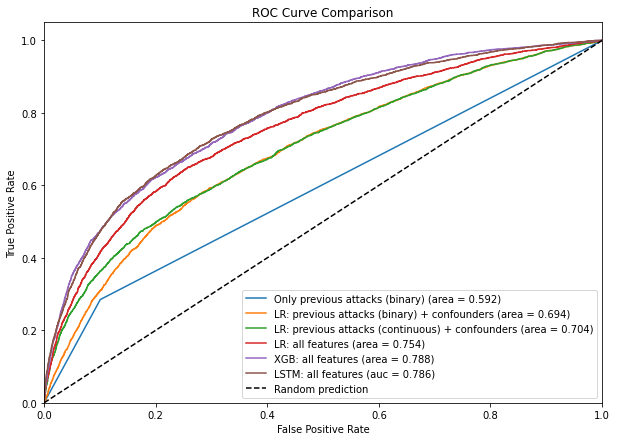

In [40]:
# Calculate ROC curve
plt.figure(figsize=(10,7))

#naive model - only previous attack
fpr1, tpr1, thresholds1 = roc_curve(X_externalVal_binary.values, y_externalVal_binary.values) 
roc_auc1 = auc(fpr1, tpr1)
# Plot the ROC curve
plt.plot(fpr1, tpr1, label='Only previous attacks (binary) (area = %0.3f)' % roc_auc1)

#previous attack + confounding in LR
preds2 = lrmodel1.predict_proba(X_externalVal)
preds2 = [x[1] for x in preds2]
fpr2, tpr2, thresholds2 = roc_curve(y_externalVal.values, preds2) 
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='LR: previous attacks (binary) + confounders (area = %0.3f)' % roc_auc2)

#previous attack (cont) + confounding in LR
preds3 = lrmodel2.predict_proba(X_externalVal_cont)
preds3 = [x[1] for x in preds3]
fpr3, tpr3, thresholds3 = roc_curve(y_externalVal.values, preds3) 
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='LR: previous attacks (continuous) + confounders (area = %0.3f)' % roc_auc3)

#LR all
preds4 = model1.predict_proba(X_externalVal_all)
preds4 = [x[1] for x in preds4]
fpr4, tpr4, thresholds4 = roc_curve(y_externalVal.values, preds4) 
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, label='LR: all features (area = %0.3f)' % roc_auc4)

#XGBoost all
preds5 = model2.predict_proba(X_externalVal_all)
preds5 = [x[1] for x in preds5]
fpr5, tpr5, thresholds5 = roc_curve(y_externalVal.values, preds5) 
roc_auc5 = auc(fpr5, tpr5)
plt.plot(fpr5, tpr5, label='XGB: all features (area = %0.3f)' % roc_auc5)

#LSTM
preds6 = lstm_model.predict([externalEvaluation_tab, externalEvaluation_X[:, :9, :]])
preds6 = [x for x in preds6]
fpr6, tpr6, thresholds6 = roc_curve(externalEvaluation_y, preds6) 
roc_auc6 = auc(fpr6, tpr6)
plt.plot(fpr6, tpr6, label='LSTM: all features (auc = %0.3f)' % roc_auc6)


plt.plot([0, 1], [0, 1], 'k--', label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Train Model

In [ ]:
#params
params_dict = pd.read_csv('../../MODELS/BS_result_new.csv')
def process_params(param_items, best_param):
    a = eval(param_items)
    b = eval(best_param)
    c = {}
    for key, value in zip(a,b):
        c[key] = value
    return c

params_dict['params'] = params_dict.apply(lambda x: dict(eval(x.best_param[11:])), axis=1)

In [ ]:
params_dict.head(10)

In [ ]:
%%time

## k-fold

#EXECUTE model training
summary_result_train = []
# summary_result_internalVal = []
# summary_result_externalVal = []

cols = ['model_name', 'fold', 'outcome', 'class_ratio', 'auc', 'auprc']
n_splits = 5
model_folder = '../MODELS/CrosVal/'

for target_outcome in target_outcomes:
    models = pd.DataFrame(columns=['modelname', 'target_outcome', 'class_ratio'])
    print(target_outcome)
    y = crossValData[target_outcome]
    # y_internalVal = internalEvaluationData[target_outcome]
    # y_externalVal = externalEvaluationData[target_outcome]
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    kf.get_n_splits(X)
    fold = 0
    
    for train_index, test_index in kf.split(X, y):
        #split data
        fold+=1
        print(f'fold: {fold}')
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #Build models -> it can be commented if the models have been trained
        models_temp = pd.DataFrame(build_models(X_train, y_train, target_outcome, params_dict, model_folder, fold), columns=['modelname', 'target_outcome', 'class_ratio'])
        models = pd.concat([models,models_temp]).reset_index(drop=True)
    
    
        #evaluate model
        for modelname, target_outcome, classratio in models_temp.values:
            # print('======================================================================')
            print(modelname)
            model = pickle.load(open('../Models/CrosVal/'+ target_outcome + '_'+ modelname + '.sav', 'rb'))       
            summary_result_train.append((modelname, fold, target_outcome, classratio, ) + summariseResult (X_test, y_test, model) )       
            # summary_result_internalVal.append((modelname, fold, target_outcome, classratio, ) + summariseResult (X_internalVal, y_internalVal, model) )       
            # summary_result_externalVal.append((modelname, fold, target_outcome, classratio, ) + summariseResult (X_externalVal, y_externalVal, model) )       

            torch.cuda.empty_cache()


summary_result_train = pd.DataFrame(summary_result_train, columns=cols)
summary_result_train['model_num'] = summary_result_train.index
summary_result_train.to_csv('../MODELS/CrossVal.csv', index_label=False, index=False)
# summary_result_internalVal = pd.DataFrame(summary_result_internalVal, columns=cols)
# summary_result_internalVal['model_num'] = summary_result_internalVal.index

# summary_result_externalVal = pd.DataFrame(summary_result_externalVal, columns=cols)
# summary_result_externalVal['model_num'] = summary_result_externalVal.index


In [ ]:
summary_result_train['set'] = 'Cross validation (England)'
summary_result_internalVal['set'] = 'Internal validation (England)'
summary_result_externalVal['set'] = 'External validation (Wales & Scotland)'


combine = pd.concat([summary_result_train, summary_result_internalVal, 
                     summary_result_externalVal,
                    ])

In [ ]:
#PLOT
data = combine
data = combine[(combine.outcome=='outcome_12months')]
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'set',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=4,
            row='outcome',
            aspect=3.5,
            errorbar = None,)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.002, 
                '{0:.3f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=7)

ax.set_ylim(0.3, .85)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=10)
# ax.set_xticklabels(fontsize=20)

# END of TRAINING

In [ ]:
X = crossValData[feature_columns_main]
X_grid = gridSearchData[feature_columns_main]
X = pd.concat([X, X_grid])
X.reset_index(drop=True, inplace=True)
X_internalVal = internalEvaluationData[feature_columns_main]
X_externalVal = externalEvaluationData[feature_columns_main]

print(X.shape)
print(X_internalVal.shape)
print(X_externalVal.shape)


target_outcomes = [
    'outcome_3months', 'outcome_6months', 'outcome_9months', 
    'outcome_12months',
] 
# target_outcomes = ['12months'] 
model_names = [
    'LR', 
    'DT', 'RF', 
    'XGB'
              ]

In [ ]:
%%time


#EXECUTE model training
summary_result_internalVal = []
summary_result_externalVal = []

# cols = ['model_name', 'outcome', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
cols = ['model_name', 'outcome', 'class_ratio', 'auc', 'auprc']
model_folder = '../../MODELS/NaiveModel/'
fold = 99 #test fold

for target_outcome in target_outcomes:
    models = pd.DataFrame(columns=['modelname', 'target_outcome', 'class_ratio'])
    print(target_outcome)
    y = crossValData[target_outcome]
    y_val = gridSearchData[target_outcome]
    y = pd.concat([y, y_val])
    y.reset_index(drop=True, inplace=True)
    y_internaleval = internalEvaluationData[target_outcome]
    y_eval = externalEvaluationData[target_outcome]
    # y_eval_Wales = evaluationDataWales[target_outcome]
    # y_eval_Scotland = evaluationDataScotland[target_outcome]
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X, y, target_outcome, params_dict, model_folder, fold), columns=['modelname', 'target_outcome', 'class_ratio'])
    models = pd.concat([models,models_temp]).reset_index(drop=True)

    #evaluate model
    for modelname, target_outcome, classratio in models.values:
        # print('======================================================================')
        print(modelname)
        model = pickle.load(open(model_folder+ target_outcome + '/'+ modelname + '.sav', 'rb'))
        summary_result_eval.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval, y_eval, model) )
        # summary_result_Wales.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Wales, y_eval_Wales, model) )       
        # summary_result_Scotland.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Scotland, y_eval_Scotland, model) )       
        summary_result_val.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_internaleval, y_internaleval, model) )       


summary_result_eval = pd.DataFrame(summary_result_eval, columns=cols)
summary_result_eval['model_num'] = summary_result_eval.index

# summary_result_Wales = pd.DataFrame(summary_result_Wales, columns=cols)
# summary_result_Wales['model_num'] = summary_result_Wales.index

# summary_result_Scotland = pd.DataFrame(summary_result_Scotland, columns=cols)
# summary_result_Scotland['model_num'] = summary_result_Scotland.index

summary_result_internaleval = pd.DataFrame(summary_result_val, columns=cols)
summary_result_internaleval['model_num'] = summary_result_val.index


In [ ]:
# summary_result_eval['model_name'] = summary_result_eval.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_val['model_name'] = summary_result_val.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_Wales['model_name'] = summary_result_Wales.apply(lambda x: modelNameFixer(x['model_name']), axis=1)
# summary_result_Scotland['model_name'] = summary_result_Scotland.apply(lambda x: modelNameFixer(x['model_name']), axis=1)

In [ ]:
# summary_result.to_csv('../Models/summary_result_test_1year.csv', index_label=False, index=False)

In [ ]:
# summary_result = pd.read_csv('../Models/summary_result.csv')

In [ ]:
# summary_result_internaleval['set'] = 'England'
# summary_result_eval['set'] = 'Wales & Scotland'
# summary_result_Wales['set'] = 'Wales'
# summary_result_Scotland['set'] = 'Scotland'

# combine = pd.concat([summary_result_internaleval, summary_result_eval, 
#                      summary_result_Wales, summary_result_Scotland,
#                     ])

In [ ]:
combine = pickle.load(open('../Models/benchmarking_result_2vs1.sav', 'rb'))

In [ ]:
combine[combine.model_name == 'LR']

In [ ]:
model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
for model_name in model_names:
    model = pickle.load(open('../Models_trainValEval/12months/'+model_name+'0.sav', 'rb'))
    preds = model.predict_proba(X_eval)
    preds = [x[1] for x in preds]
    fpr, tpr, thresholds = roc_curve(y_eval, preds, pos_label=1)
    auc = np.round(roc_auc_score(y_eval, preds), 4)
    plt.plot(fpr,tpr,label=model_name+", auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
model_names = ['LR', 'Lasso', 'Elastics', 'DT', 'RF', 'XGB']
for model_name in model_names:
    for target_outcome in target_outcomes:
        y_eval = evaluationData[target_outcome]
        model = pickle.load(open('../Models_trainValEval/'+target_outcome+'/'+model_name+'0.sav', 'rb'))
        preds = model.predict_proba(X_eval)
        preds = [x[1] for x in preds]
        fpr, tpr, thresholds = roc_curve(y_eval, preds, pos_label=1)
        auc = np.round(roc_auc_score(y_eval, preds), 4)
        plt.plot(fpr,tpr,label=target_outcome+", auc="+str(auc))
    plt.legend(loc=4)
    plt.title(model_name)
    plt.show()

In [ ]:
model_folder = '../Models_trainValEval/'
summary_result_val = []
summary_result_eval = []
summary_result_Wales = []
summary_result_Scotland = []
cols = ['model_name', 'outcome', 'auc', 'auprc']
for target_outcome in target_outcomes:
    y = trainingData[target_outcome]
    y_val = validationData[target_outcome]
    y = pd.concat([y, y_val])
    y_internaleval = internalEvaluationData[target_outcome]
    y_eval = evaluationData[target_outcome]
    y_eval_Wales = evaluationDataWales[target_outcome]
    y_eval_Scotland = evaluationDataScotland[target_outcome]
    for model_name in model_names:
        # print('======================================================================')
        # print(model_name)
        model = pickle.load(open(model_folder+ target_outcome + '/'+ model_name + '0.sav', 'rb'))
        summary_result_eval.append((str(model_name),target_outcome,) + summariseResult (X_eval, y_eval, model) )
        summary_result_Wales.append((str(model_name),target_outcome,) + summariseResult (X_eval_Wales, y_eval_Wales, model) )       
        summary_result_Scotland.append((str(model_name),target_outcome,) + summariseResult (X_eval_Scotland, y_eval_Scotland, model) )       
        summary_result_val.append((str(model_name),target_outcome,) + summariseResult (X_internaleval, y_internaleval, model) )   

    
summary_result_eval = pd.DataFrame(summary_result_eval, columns=cols)
summary_result_eval['model_num'] = summary_result_eval.index

summary_result_Wales = pd.DataFrame(summary_result_Wales, columns=cols)
summary_result_Wales['model_num'] = summary_result_Wales.index

summary_result_Scotland = pd.DataFrame(summary_result_Scotland, columns=cols)
summary_result_Scotland['model_num'] = summary_result_Scotland.index

summary_result_internaleval = pd.DataFrame(summary_result_val, columns=cols)
summary_result_internaleval['model_num'] = summary_result_val.index
summary_result_internaleval['set'] = 'England'
summary_result_eval['set'] = 'Wales & Scotland'
summary_result_Wales['set'] = 'Wales'
summary_result_Scotland['set'] = 'Scotland'

combine = pd.concat([summary_result_internaleval, summary_result_eval, 
                     summary_result_Wales, summary_result_Scotland,
                    ])

In [ ]:
data = combine
data = combine[(combine.outcome=='12months')]
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'set',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=4,
            row='outcome',
            aspect=3.5,
            errorbar = None,)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.002, 
                '{0:.4f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=7)

ax.set_ylim(0.6, .81)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=10)
# ax.set_xticklabels(fontsize=20)

In [ ]:
data = combine
# data = combine[(combine.outcome=='12months')]
data = combine[(combine.set=='Wales & Scotland')]
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'set',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=3,
            row='outcome',
            aspect=1.5,
            errorbar = None,legend=False, sharex=False)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.002, 
                '{0:.4f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=7)

ax.set_ylim(0.6, .81)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=10)
# ax.set_xticklabels(fontsize=20)

In [ ]:
pickle.dump(combine, open('../Models/benchmarking_result.sav', 'wb'))

## Calibration

In [ ]:
def summariseResultCalibration (testX, testY, model, threshold):
    preds = model.predict_proba(testX)
    preds = [0 if x[1] < threshold else 1 for x in preds]
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    aucscore = roc_auc_score(testY, preds)
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4), np.round(aucscore,4)



In [ ]:
calibrationResult = []
model_names = ['LR', 'DT', 'RF', 'XGB']
for model_name in model_names:
    for target_outcome in target_outcomes:
        model = pickle.load(open('../MODELS/TestResult/'+target_outcome+'_'+model_name+'.sav', 'rb'))
        y_externalVal = externalEvaluationData[target_outcome]
        preds = model.predict_proba(X_externalVal)
        preds = [x[1] for x in preds]
        fpr, tpr, thresholds = roc_curve(y_externalVal, preds)
        optimal_idx = np.argmax(tpr - fpr)# Find optimal probability threshold
        threshold = thresholds[optimal_idx]
        calibrationResult.append(((target_outcome, model_name, threshold)+summariseResultCalibration(X_externalVal, y_externalVal, model, threshold)))

cols = ['outcome', 'model', 'threshold', 'acc', 'sens', 'spec', 'balanced_acc', 'f1', 'ppv' , 'npv', 'auc']
pd.DataFrame(calibrationResult, columns = cols)

# Feature importance

In [ ]:
best_model_dt = pickle.load(open('../Models_trainValEval/12months/DT0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

In [ ]:
best_model_dt = pickle.load(open('../Models_trainValEval/12months/RF0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()
rftop10 = X.columns[sorted_idx][-10:]

In [ ]:
best_model_dt = pickle.load(open('../Models_trainValEval/12months/XGB0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.show()
xgbtop10 = X.columns[sorted_idx][-10:]

In [ ]:
best_model_lr = pickle.load(open('../Models_trainValEval/12months/LR0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_lr.coef_[0].argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_lr.coef_[0][sorted_idx][-10:])
plt.xlabel("LR Feature Importance")
plt.show()
lrtop10 = X.columns[sorted_idx][-10:]

In [ ]:
best_model_lasso = pickle.load(open('../Models_trainValEval/12months/Lasso0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_lasso.coef_[0].argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_lasso.coef_[0][sorted_idx][-10:])
plt.xlabel("Lasso Feature Importance")
plt.show()
lassotop10 = X.columns[sorted_idx][-10:]

In [ ]:
best_model_lasso = pickle.load(open('../Models_trainValEval/12months/Elastics0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_lasso.coef_[0].argsort()
plt.figure(figsize=(3,4))
plt.barh(X.columns[sorted_idx][-10:], best_model_lasso.coef_[0][sorted_idx][-10:])
plt.xlabel("Elastics Feature Importance")
plt.show()
elasticstop10 = X.columns[sorted_idx][-10:]

In [ ]:
list(set(xgbtop10).intersection(set(lassotop10)))

In [ ]:
model2visualise = pickle.load(open('../Models_trainValEval/12months/DT0.sav', 'rb'))
prune_duplicate_leaves(model2visualise)
fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(model2visualise, 
                   feature_names=X.columns,  
                   class_names=['no asthma attack','asthma attack'],
                   filled=True,)
# plt.savefig('../FinalData/dt.png',format='png',bbox_inches = "tight")

## Minimum depth DT

In [ ]:
%%time
#DT with minimum max of depth

#EXECUTE model training
X = trainingData[features_columns]
# X_test = evaluationData[features_columns]
target_outcome = '12months'

print(target_outcome)
y = trainingData[target_outcome]
y_test = evaluationData[target_outcome]
#Build models -> it can be commented if the models have been trained

# if os.path.isfile('../Models_trainValEval/dt_minimum_depth.sav'):
#     dt_model = pickle.load(open('../Models_trainValEval/dt_minimum_depth.sav', 'rb'))
# else:
dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=4, splitter='random', random_state=1234)
dt_model.fit(X, y)
pickle.dump(dt_model, open('../Models_trainValEval/dt_minimum_depth.sav', 'wb'))    
    

print(summariseResult (X_val, y_val, dt_model))
print(summariseResult (X_eval, y_eval, dt_model))
print(summariseResult (X_eval_Wales, y_eval_Wales, dt_model))
print("DT done")

In [ ]:
prune_duplicate_leaves(dt_model)
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(dt_model, 
                   feature_names=X.columns,  
                   class_names=['no asthma attack','asthma attack'],
                   filled=True)
plt.savefig('../FinalData/dt_minimumdepth.png',format='png',bbox_inches = "tight")

In [ ]:
scaler = pickle.load(open('../Models_trainValEval/cont_scaler.pkl', 'rb'))
continuous_vars = ['age', 'CharlsonScore', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 
                   'numOCS', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI', 
                   'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents']

In [ ]:
DataOfInterest_cont = pd.DataFrame(scaler.inverse_transform(trainingData[continuous_vars]), columns=scaler.get_feature_names_out())

In [ ]:
VarOfInterest = ['numOCS', 'numPCS']
additionalVars = ['prescribed_daily_dose_ICS', 'numAntibioticsEvents', 'ICS_medication_possesion_ratio', 'numAsthmaAttacks', 'numAntibioticswithLRTI', 'age']
DataOfInterest = pd.concat((DataOfInterest_cont, trainingData[['BTS_step', 'imd_decile_0']+target_outcomes]), axis=1)
#solve little problem with inverse scaling:
DataOfInterest['numAsthmaAttacks'] = DataOfInterest.numAsthmaAttacks.apply(lambda x: 0 if x<1 else x)
DataOfInterest['numOCSwithLRTI'] = DataOfInterest.numOCSwithLRTI.apply(lambda x: 0 if x<1 else x)
DataOfInterest['numHospEvents'] = DataOfInterest.numHospEvents.apply(lambda x: 0 if x<1 else x)
DataOfInterest.head()

In [ ]:
scaler.feature_names_in_

In [ ]:
depth3_1 = [[0, 0, 0,
       0, 0,
       0.041, -1.086, 0, 0,
       0, 0, 0,
       0, 0, 0]]

depth3_2 = [[0, 0, 0,
       0, 0,
       0.583, -1.086, 0, 0,
       0, 0, 0,
       0, 0, 0]]

depth4_1 = [[0, -0.822, 0,
       0, 0,
       0.041, -0.23, 0, 0,
       0, 0, 0,
       2.493, 0, 0]]

depth4_2 = [[0, -0.822, 0,
       0, 0,
       0.583, -1.02, 0, 0,
       0, 0, 0,
       2.493, 0, 0]]

In [ ]:
scaler.inverse_transform(depth3_1)

In [ ]:
scaler.inverse_transform(depth3_2)

In [ ]:
scaler.inverse_transform(depth4_1)

In [ ]:
scaler.inverse_transform(depth4_2)

In [ ]:
DataOfInterest.CharlsonScore.hist()

In [ ]:
preds_dt = best_model_dt.predict(trainingData[features_columns])
preds_lasso = best_model_lasso.predict(trainingData[features_columns])
prediction_table = pd.DataFrame([trainingData['12months'], preds_dt, preds_lasso]).T
prediction_table.columns = ['y_true', 'y_pred_dt', 'y_pred_lasso']

In [ ]:
false_positive = prediction_table[(prediction_table.y_pred_dt==1) & (prediction_table.y_true!=prediction_table.y_pred_dt)]
false_negative = prediction_table[(prediction_table.y_pred_dt==0) & (prediction_table.y_true!=prediction_table.y_pred_dt)]
true_positive = prediction_table[(prediction_table.y_pred_dt==1) & (prediction_table.y_true==prediction_table.y_pred_dt)]
true_negative = prediction_table[(prediction_table.y_pred_dt==0) & (prediction_table.y_true==prediction_table.y_pred_dt)]

In [ ]:
print('True Pos')
print(DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']].describe())
print('-----------------------------------------------------------------------------------')
print('False Neg')
print(DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']].describe())
print('-----------------------------------------------------------------------------------')
# print('False Pos')
# print(DataOfInterest.iloc[false_positive.index][VarOfInterest+['BTS_step']].describe())
# print('-----------------------------------------------------------------------------------')
# print('True Neg')
# print(DataOfInterest.iloc[true_negative.index][VarOfInterest+['BTS_step']].describe())

In [ ]:
fig, ax = plt.subplots()
DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']].boxplot(ax=ax)
ax.set_ylim(-50,400)
plt.show()
print('-----------------------------------------------------------------------------------')
fig, ax = plt.subplots()
DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']].boxplot()
ax.set_ylim(-50,400)
plt.show()
print('-----------------------------------------------------------------------------------')
fig, ax = plt.subplots()
DataOfInterest.iloc[true_negative.index][VarOfInterest+['BTS_step']].boxplot()
ax.set_ylim(-50,400)
plt.show()

In [ ]:
print(DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']+additionalVars+['imd_decile_0']].describe())
print('-----------------------------------------------------------------------------------')
print(DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']+additionalVars+['imd_decile_0']].describe())
print('-----------------------------------------------------------------------------------')
print(DataOfInterest.iloc[true_negative.index][VarOfInterest+['BTS_step']+additionalVars+['imd_decile_0']].describe())

In [ ]:
DataOfInterest.iloc[true_positive.index][VarOfInterest+['BTS_step']].sample(n=20, random_state=1234)

In [ ]:
DataOfInterest.iloc[false_negative.index][VarOfInterest+['BTS_step']].sample(n=20, random_state=1234)

## Run models only on the subset of BTS == 1

In [ ]:
trainingDataSubset = trainingData[(trainingData.BTS_step < 7)]
validationDataSubset = validationData[(validationData.BTS_step < 7) ]
evaluationDataSubset = evaluationData[(evaluationData.BTS_step < 7)]
evaluationDataWalesSubset = evaluationDataWales[(evaluationDataWales.BTS_step < 7) ]
evaluationDataScotlandSubset = evaluationDataScotland[(evaluationDataScotland.BTS_step < 7)]

In [ ]:
#encode categorical data

# cat_vars = ['PEFStatus','EosinophilLevel']
onehot_vars = ['BTS_step']
# data_categorical = trainingData[cat_vars]
data_onehot = trainingDataSubset[onehot_vars]

# #ordinal encoder
# encoder = OrdinalEncoder(categories=[['not_recorded','less than 60', '60-80', 'more than 80'], ['unknown', 'normal', 'high']]).set_output(transform="pandas")
# data_encoded = encoder.fit_transform(data_categorical)
# pickle.dump(encoder, open('../Models/cat_encoder.pkl', 'wb'))
    
#one hot encoder
onehot_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
onehot_encoded = onehot_encoder.fit_transform(data_onehot)
# pickle.dump(onehot_encoder, open('../Models/onehot_encoder.pkl', 'wb'))

# trainingDataSubset = pd.concat([trainingDataSubset.drop(cat_vars, axis=1), data_encoded], axis=1)
trainingDataSubset = pd.concat([trainingDataSubset.drop(onehot_vars, axis=1), onehot_encoded], axis=1)

print('Data shape after encoding: ', trainingDataSubset.shape)

In [ ]:
#encode cat vars for validation and evaluation set
# data_val_categorical = validationData[cat_vars]
data_val_onehot = validationDataSubset[onehot_vars]
# data_eval_categorical = evaluationData[cat_vars]
data_eval_onehot = evaluationDataSubset[onehot_vars]
# data_eval_Wales_categorical = evaluationDataWales[cat_vars]
data_eval_Wales_onehot = evaluationDataWalesSubset[onehot_vars]
# data_eval_Scotland_categorical = evaluationDataScotland[cat_vars]
data_eval_Scotland_onehot = evaluationDataScotlandSubset[onehot_vars]

# encoder = pickle.load(open('../Models/cat_encoder.pkl', 'rb'))
# data_val_encoded = encoder.transform(data_val_categorical)
# data_eval_encoded = encoder.transform(data_eval_categorical)
# data_eval_Wales_encoded = encoder.transform(data_eval_Wales_categorical)
# data_eval_Scotland_encoded = encoder.transform(data_eval_Scotland_categorical)

# onehot_encoder = pickle.load(open('../Models/onehot_encoder.pkl', 'rb'))
onehot_val_encoded = onehot_encoder.transform(data_val_onehot)
onehot_eval_encoded = onehot_encoder.transform(data_eval_onehot)
onehot_eval_Wales_encoded = onehot_encoder.transform(data_eval_Wales_onehot)
onehot_eval_Scotland_encoded = onehot_encoder.transform(data_eval_Scotland_onehot)

# validationDataSubset = pd.concat([validationDataSubset.drop(cat_vars, axis=1), data_val_encoded], axis=1)
validationDataSubset = pd.concat([validationDataSubset.drop(onehot_vars, axis=1), onehot_val_encoded], axis=1)

# evaluationDataSubset = pd.concat([evaluationDataSubset.drop(cat_vars, axis=1), data_eval_encoded], axis=1)
evaluationDataSubset = pd.concat([evaluationDataSubset.drop(onehot_vars, axis=1), onehot_eval_encoded], axis=1)

# evaluationDataWalesSubset = pd.concat([evaluationDataWalesSubset.drop(cat_vars, axis=1), data_eval_Wales_encoded], axis=1)
evaluationDataWalesSubset = pd.concat([evaluationDataWalesSubset.drop(onehot_vars, axis=1), onehot_eval_Wales_encoded], axis=1)

# evaluationDataScotlandSubset = pd.concat([evaluationDataScotlandSubset.drop(cat_vars, axis=1), data_eval_Scotland_encoded], axis=1)
evaluationDataScotlandSubset = pd.concat([evaluationDataScotlandSubset.drop(onehot_vars, axis=1), onehot_eval_Scotland_encoded], axis=1)

print('Val data shape after encoding: ', validationDataSubset.shape)
print('Eval data shape after encoding: ', evaluationDataSubset.shape)
print('Evaluation data Wales shape: ', evaluationDataWalesSubset.shape)
print('Evaluation data Scotland shape: ', evaluationDataScotlandSubset.shape)

In [ ]:
trainingDataSubset.shape

In [ ]:
trainingDataSubset.columns

In [ ]:
features_columns.remove('BTS_step')
features_columns = features_columns + ['BTS_step_0.0', 'BTS_step_1.0', 'BTS_step_2.0',
                                       'BTS_step_3.0', 'BTS_step_4.0', 'BTS_step_5.0']
features_columns

In [ ]:
X_subset = trainingDataSubset[features_columns]
X_val_subset = validationDataSubset[features_columns]
X_eval_subset = evaluationDataSubset[features_columns]
X_eval_Wales_subset = evaluationDataWalesSubset[features_columns]
X_eval_Scotland_subset = evaluationDataScotlandSubset[features_columns]
target_outcomes = ['3months', '6months', '12months', '24months'] 

In [ ]:
X_subset.shape

In [ ]:
X_subset.shape[0]/trainingData.shape[0]

In [ ]:
%%time


#EXECUTE model training
summary_result_val_subset = []
summary_result_eval_subset = []
summary_result_Wales_subset = []
summary_result_Scotland_subset = []
cols = ['model_name', 'outcome', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
model_folder = '../Models_subsetBTS/'
fold = 0

for target_outcome in target_outcomes:
    models = pd.DataFrame(columns=['modelname', 'target_outcome', 'class_ratio'])
    print(target_outcome)
    y_subset = trainingDataSubset[target_outcome]
    y_val_subset = validationDataSubset[target_outcome]
    y_eval_subset = evaluationDataSubset[target_outcome]
    y_eval_Wales_subset = evaluationDataWalesSubset[target_outcome]
    y_eval_Scotland_subset = evaluationDataScotlandSubset[target_outcome]
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X_subset, y_subset, target_outcome, params_dict, model_folder, fold), columns=['modelname', 'target_outcome', 'class_ratio'])
    models = pd.concat([models,models_temp]).reset_index(drop=True)

    #evaluate model
    for modelname, target_outcome, classratio in models.values:
        # print('======================================================================')
        print(modelname)
        model = pickle.load(open(model_folder+ target_outcome + '/'+ modelname + '.sav', 'rb'))
        summary_result_eval_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_subset, y_eval_subset, model) )
        summary_result_Wales_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Wales_subset, y_eval_Wales_subset, model) )       
        summary_result_Scotland_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_eval_Scotland_subset, y_eval_Scotland_subset, model) )       
        summary_result_val_subset.append((str(modelname), target_outcome, classratio, ) + summariseResult (X_val_subset, y_val_subset, model) )       


summary_result_eval_subset = pd.DataFrame(summary_result_eval_subset, columns=cols)
summary_result_eval_subset['model_num'] = summary_result_eval_subset.index

summary_result_Wales_subset = pd.DataFrame(summary_result_Wales_subset, columns=cols)
summary_result_Wales_subset['model_num'] = summary_result_Wales_subset.index

summary_result_Scotland_subset = pd.DataFrame(summary_result_Scotland_subset, columns=cols)
summary_result_Scotland_subset['model_num'] = summary_result_Scotland_subset.index

summary_result_val_subset = pd.DataFrame(summary_result_val_subset, columns=cols)
summary_result_val_subset['model_num'] = summary_result_val_subset.index


In [ ]:
summary_result_val_subset['set'] = 'val'
summary_result_eval_subset['set'] = 'eval'
summary_result_Wales_subset['set'] = 'Wales'
summary_result_Scotland_subset['set'] = 'Scotland'

combine_subset = pd.concat([summary_result_val_subset, summary_result_eval_subset, 
                     summary_result_Wales_subset, summary_result_Scotland_subset,
                    ])

In [ ]:
data = combine_subset
# data = combine[combine.set!='Training Set']
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'set',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=5,
            row='outcome',
            aspect=3,
            errorbar = None,)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.005, 
                '{0:.4f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=8)

ax.set_ylim(0.55, 0.76)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=13)

In [ ]:
best_model_dt = pickle.load(open('../Models_subsetBTS/12months/DT0.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(3,4))
plt.barh(X_subset.columns[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

# Novelty detection

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest



In [ ]:
def summariseResultNovelty (testX, testY, model, modelname):
    if modelname == 'Gaussian Mixture':
        preds = model.predict_proba(testX)[:,1]
        aucscore = roc_auc_score(testY, preds)
    else:
        # scaller = MinMaxScaler()
        # preds = scaller.fit_transform(model.decision_function(testX).reshape(-1, 1))[:,0]
        preds = model.predict(testX)
        preds = [0 if x == 1 else 1 for x in preds]
        fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
        aucscore = auc(fpr, tpr)
    
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(aucscore,4), np.round(auprc,4)
    # return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)

In [ ]:
contamination = y.value_counts()[1]/y.shape[0]

In [ ]:
ignore, use = train_test_split(trainingData, stratify=trainingData['12months'], test_size=.2)
print(use.shape)


In [ ]:
y.values

In [ ]:
%%time

#hyperparameter search
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

#Bayesiain continuous search


X = use[features_columns]
cv = StratifiedKFold(n_splits=3)
n_calls = 10
n_jobs = 10

output = []

for target_outcome in target_outcomes:
    print('######################################################################################################')
    print(target_outcome)
    y = use[target_outcome]
    scale_pos_ratio = y.value_counts()[0]/y.value_counts()[1]
    
#     if target_outcome == 'outcome_combined_24months':   
#   ##############################################################################
    print('#IF')
    IF = IsolationForest(contamination=contamination, random_state=1234)
    IF_params = [Integer(100, 500, "uniform", name='n_estimators'),
                 Categorical([True, False], name = 'bootstrap')]
    
    @use_named_args(IF_params)
    def IF_objective(**params):
        IF.set_params(**params)

        return 1-np.mean(cross_val_score(IF, X.values, y.values, cv=cv,
                                        scoring=make_scorer(roc_auc_score)))

    res_gp_IF = gp_minimize(IF_objective, IF_params, n_calls=n_calls, random_state=1234, verbose=3, n_jobs=n_jobs)
    output.append([target_outcome, 'IF', 1-res_gp_IF.fun, res_gp_IF.x])
    
    GM = GaussianMixture(n_components=2, random_state=1234)
    GM_params = [Categorical(['liblinear', 'newton-cholesky'], name = 'solver'),
                 Real(0.1, 10, 'log-uniform', name='C'), 
                 Integer(50, 200, 'uniform', name='max_iter')]

    
    ########################################################################################
    print('#EE')
    EE = EllipticEnvelope(contamination=contamination, random_state=1234)
    
    EE_params = [Categorical([True, False], name = 'assume_centered')]
    
    @use_named_args(EE_params)
    def EE_objective(**params):
        EE.set_params(**params)

        return 1-np.mean(cross_val_score(EE, X.values, y.values, cv=cv,
                                        scoring=make_scorer(roc_auc_score)))

    res_gp_EE = gp_minimize(EE_objective, EE_params, n_calls=n_calls, random_state=1234, verbose=3, n_jobs=n_jobs)
    output.append([target_outcome, 'EE', 1-res_gp_EE.fun, res_gp_EE.x])

########################################################################################

    print('#GM')
    GM = GaussianMixture(random_state=1234)
    GM_params = [Categorical(['full', 'tied', 'diag', 'spherical'], name = 'covariance_type'),
                 Categorical(['kmeans', 'random'], name = 'init_params'),
                 Integer(50, 200, 'uniform', name='max_iter'),
                 Integer(1, 3, 'uniform', name='n_components')]

    @use_named_args(GM_params)
    def GM_objective(**params):
        GM.set_params(**params)

        return 1-np.mean(cross_val_score(GM, X.values, y.values, cv=cv,
                                        scoring=make_scorer(roc_auc_score)))

    res_gp_GM = gp_minimize(GM_objective, GM_params, n_calls=n_calls, random_state=1234, verbose=3, n_jobs=n_jobs)
    output.append([target_outcome, 'GM', 1-res_gp_GM.fun, res_gp_GM.x])
    
    

########################################################################################

In [ ]:
pd.DataFrame(output, columns=['outcome', 'model', 'best_score', 'best_param']).to_csv('../Models/BS_novelty.csv', index = False, index_label=False)

In [ ]:
pd.DataFrame(output, columns=['outcome', 'model', 'best_score', 'best_param'])

In [ ]:
params_dict = pd.read_csv('../Models/BS_novelty.csv')
def process_params(param_items, best_param):
    a = eval(param_items)
    b = eval(best_param)
    c = {}
    for key, value in zip(a,b):
        c[key] = value
    return c

params_dict['params'] = params_dict.apply(lambda x: process_params(x.param_items, x.best_param), axis=1)
params_dict.head()

In [ ]:
def novelty_models(modelname, target_outcome, params, contamination):
    if modelname == 'Isolation Forest':
        params = params[(params.model == 'IF')&(params.outcome == target_outcome)]['params'].tolist()[0]
        model = IsolationForest(n_estimators=params['n_estimators'], bootstrap = params['bootstrap'], contamination=contamination, random_state=1234)
    elif modelname=='Elliptic Envelope':
        params = params[(params.model == 'EE')&(params.outcome == target_outcome)]['params'].tolist()[0]
        model = EllipticEnvelope(assume_centered=params['assume_centered'], contamination=contamination, random_state=1234)
    elif modelname=='Gaussian Mixture':
        params = params[(params.model == 'GM')&(params.outcome == target_outcome)]['params'].tolist()[0]
        model = GaussianMixture(covariance_type=params['covariance_type'], init_params=params['init_params'], max_iter=params['max_iter'], n_components=2, random_state=1234)
    return model

In [ ]:
modelnames = ['Isolation Forest', 'Elliptic Envelope', 'Gaussian Mixture']
summary_result_internal_eval = []
summary_result_eval = []
summary_result_eval_Wales = []
summary_result_eval_Scotland = []
for target_outcome in target_outcomes:
    y = trainingData[target_outcome]
    y_val = validationData[target_outcome]
    y = pd.concat([y, y_val])
    y_internaleval = internalEvaluationData[target_outcome]
    y_eval = evaluationData[target_outcome]
    y_eval_Wales = evaluationDataWales[target_outcome]
    y_eval_Scotland = evaluationDataScotland[target_outcome]
    contamination = y.value_counts()[1]/y.shape[0]
    for modelname in modelnames:
        model = novelty_models(modelname, target_outcome, params_dict, contamination)
        model.fit(X)
        summary_result_internal_eval.append((str(modelname), target_outcome, ) + summariseResultNovelty (X_internaleval, y_internaleval.values, model, modelname))
        summary_result_eval.append((str(modelname), target_outcome, ) + summariseResultNovelty (X_eval, y_eval.values, model, modelname))
        summary_result_eval_Wales.append((str(modelname), target_outcome, ) + summariseResultNovelty (X_eval_Wales, y_eval_Wales.values, model, modelname))
        summary_result_eval_Scotland.append((str(modelname), target_outcome, ) + summariseResultNovelty (X_eval_Scotland, y_eval_Scotland.values, model, modelname))

In [ ]:
summary_result_eval = pd.DataFrame(summary_result_eval, columns=['model', 'outcome', 'AUC', 'AUPRC'])

In [ ]:
g = sns.FacetGrid(summary_result_eval, col='outcome', col_wrap=2, height=3, aspect=1.6, ylim=(0.4, 0.7))
g.map(sns.barplot, 'model', 'AUC', order=summary_result_eval.model.unique()).add_legend()

for ax in g.axes:
    for p in ax.patches:
             ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                 textcoords='offset points')
    ax.set_ylabel('AUC Score', fontsize=8)
    ax.set_xlabel('Method', fontsize=11)

In [ ]:
model = GaussianMixture(n_components=2, random_state=1234)
model.fit(X)
preds = model.predict(X_eval)

In [ ]:
np.count_nonzero(preds)

In [ ]:
confusion_matrix(y_eval, preds)